# Load dependencies and tables

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Markdown as md

In [3]:
output_tables = "output_tables"
run_dir_name = "2024_11_18_16_07_output"
run_dir = os.path.join(output_tables, run_dir_name)

df_sample_mapping = pd.read_csv(os.path.join(output_tables, "sample_mapping.csv"))

df_filter_mapping_full = pd.read_csv(os.path.join(run_dir, "filter_mapping_full.csv"))
df_filter_mapping = pd.read_csv(os.path.join(run_dir, "filter_mapping.csv"))
df_truncate_mapping = pd.read_csv(os.path.join(run_dir, "truncate_mapping.csv"))

df_refseq_full = pd.read_csv(os.path.join(run_dir, "refseq_table_pk_full.csv"))
df_refseq = pd.read_csv(os.path.join(run_dir, "refseq_table_pk.csv"))

df_refseq_srr_mapping_full = pd.read_csv(os.path.join(run_dir, "mapping_table_pk_zotu_srr_full.csv"))
df_refseq_srr_mapping = pd.read_csv(os.path.join(run_dir, "mapping_table_pk_zotu_srr.csv"))

df_refseq_tax_full = pd.read_csv(os.path.join(run_dir, "tax_refseq_table_pk_full.csv"))
df_refseq_tax = pd.read_csv(os.path.join(run_dir, "tax_refseq_table_pk.csv"))

In [19]:
# Merged table for analyzing results
df = df_sample_mapping.merge(df_truncate_mapping, on=["srr_name"], how="right")
df = df.merge(df_filter_mapping_full, on=["srr_name", "zotu_id"], how="left")
df = df.merge(df_filter_mapping.rename(columns={"zotu_id": "trunc_zotu_id"}), on=["srr_name", "trunc_zotu_id"],
              suffixes=("_full", "_trunc"), how="left")
df = df.merge(df_refseq_srr_mapping_full, on=["srr_name", "zotu_id"], how="left")
df = df.merge(df_refseq_srr_mapping.rename(columns={"zotu_id": "trunc_zotu_id"}),
                                                        on=["srr_name", "trunc_zotu_id"], suffixes=("_full", "_trunc"), how="left")

df_refseq_tax_merged = df_refseq.merge(df_refseq_tax, on=["refsequence_pk"], how="left", indicator=True)
df_refseq_tax_merged["tax_missing"] = df_refseq_tax_merged["UNITE_id"].isna()
df_refseq_tax_merged = df_refseq_tax_merged.drop(columns=["_merge"])

df_refseq_tax_merged_full = df_refseq_full.merge(df_refseq_tax_full, on=["refsequence_pk"], how="left", indicator=True)
df_refseq_tax_merged_full["tax_missing"] = df_refseq_tax_merged_full["UNITE_id"].isna()
df_refseq_tax_merged_full = df_refseq_tax_merged_full.drop(columns=["_merge"])

df = df.merge(df_refseq_tax_merged_full.rename(
    columns={"refsequence_pk": "refsequence_pk_full", "sequence": "sequence_full"}),
    on=["refsequence_pk_full", "sequence_full"], how="left")
df = df.merge(df_refseq_tax_merged.rename(
    columns={"refsequence_pk": "refsequence_pk_trunc", "sequence": "sequence_trunc"}),
    on=["refsequence_pk_trunc", "sequence_trunc"], suffixes=("_full", "_trunc"), how="left")

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65595 entries, 0 to 65594
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   srr_name              65595 non-null  object 
 1   plot                  65595 non-null  object 
 2   subplot               65588 non-null  float64
 3   location              65595 non-null  object 
 4   zotu_id               65595 non-null  object 
 5   trunc_zotu_id         64279 non-null  object 
 6   passed_trunc          65595 non-null  bool   
 7   passed_abun_full      65595 non-null  bool   
 8   passed_contam_full    65595 non-null  bool   
 9   passed_abun_trunc     64279 non-null  object 
 10  passed_contam_trunc   64279 non-null  object 
 11  refsequence_pk_full   6033 non-null   object 
 12  sequence_full         6033 non-null   object 
 13  refsequence_pk_trunc  6532 non-null   object 
 14  sequence_trunc        6532 non-null   object 
 15  marker_type_full   

None

# Filter results within samples

In [20]:
#Filter results on full length ZOTUs
df_filter_counts = pd.DataFrame.join(
    df.value_counts(subset=['passed_abun_full', 'passed_contam_full']),
    df.value_counts(subset=['passed_abun_full', 'passed_contam_full'], normalize=True))
df_filter_counts.loc[(True,""),:] = df_filter_counts.loc[(True, slice(None))][['count', 'proportion']].sum()
display(md("## Filter results on full length ZOTUs"))
display(md(f"Of all {df.shape[0]} full length ZOTUs found across all samples:"))
display(df_filter_counts)

num_passed_abun = df_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_filter_counts.loc[(True, '')]['proportion']
num_passed_contam = df_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
display(md(f"- {num_passed_abun} ({prop_passed_abun:.2%}) passed the abundance filter\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) passed the contamination filter"))

## Filter results on full length ZOTUs

Of all 65595 full length ZOTUs found across all samples:

count  proportion
passed_abun_full passed_contam_full                     
False            False               59470.0    0.906624
True             True                 6033.0    0.091973
                 False                  92.0    0.001403
                                      6125.0    0.093376

- 6125.0 (9.34%) passed the abundance filter
- 6033.0 (9.20% of all, 98.50% of abundant) passed the contamination filter

In [21]:
# Truncation results on full length ZOTUs
df_trunc = df[df["passed_trunc"] == True]
df_trunc_derep = df_trunc.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])
df_trunc_counts = pd.DataFrame.join(
    df.value_counts(subset="passed_trunc"),
    df.value_counts(subset="passed_trunc", normalize=True))
df_trunc_counts = df_trunc_counts.join(
    df_trunc_derep.value_counts(subset="passed_trunc"), rsuffix=" derep")
display(md("## Truncation results on full length ZOTUs"))
display(md(f"Of all {df.shape[0]} full length ZOTUs found across all samples:"))
display(df_trunc_counts)

num_passed_trunc = df_trunc_counts.loc[True]['count']
prop_passed_trunc = df_trunc_counts.loc[True]['proportion']
num_not_passed_trunc = df_trunc_counts.loc[False]['count']
prop_not_passed_trunc = df_trunc_counts.loc[False]['proportion']
display(md(f"- {num_passed_trunc} ({prop_passed_trunc:.2%}) passed truncation\n"
           f"\t- {df_trunc_counts.loc[True]['count derep']} after dereplication within samples\n"
           f"- {num_not_passed_trunc} ({prop_not_passed_trunc:.2%}) did not pass truncation (<250bp) and are discarded"))

## Truncation results on full length ZOTUs

Of all 65595 full length ZOTUs found across all samples:

,count,proportion,count derep
passed_trunc,,,
True,64279,0.979937,61373.0
False,1316,0.020063,NaN


- 64279.0 (97.99%) passed truncation
	- 61373.0 after dereplication within samples
- 1316.0 (2.01%) did not pass truncation (<250bp) and are discarded

In [22]:
# Filter results on discarded ZOTUs
df_discard = df[df["passed_trunc"] == False]
df_discard_filter_counts = pd.DataFrame.join(
    df_discard.value_counts(subset=['passed_abun_full', 'passed_contam_full']),
    df_discard.value_counts(subset=['passed_abun_full', 'passed_contam_full'], normalize=True))
df_discard_filter_counts.loc[(True,""),:] = df_discard_filter_counts.loc[(True, slice(None))][['count', 'proportion']].sum()
display(md("## Filter results on discarded ZOTUs"))
display(md(f"Of the {df_discard.shape[0]} full length ZOTUs that do not pass truncation (<250bp):"))
display(df_discard_filter_counts)

num_passed_abun = df_discard_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_discard_filter_counts.loc[(True, '')]['proportion']
num_passed_contam = df_discard_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_discard_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
display(md(f"- {num_passed_abun} ({prop_passed_abun:.2%}) would have passed the abundance filter\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) would have passed the contamination filter"))

## Filter results on discarded ZOTUs

Of the 1316 full length ZOTUs that do not pass truncation (<250bp):

count  proportion
passed_abun_full passed_contam_full                    
False            False               1254.0    0.952888
True             True                  47.0    0.035714
                 False                 15.0    0.011398
                                       62.0    0.047112

- 62.0 (4.71%) would have passed the abundance filter
- 47.0 (3.57% of all, 75.81% of abundant) would have passed the contamination filter

In [23]:
# Filter results on truncated ZOTUs
df_trunc_filter_counts = pd.DataFrame.join(
    df_trunc.value_counts(subset=['passed_abun_trunc','passed_contam_trunc']),
    df_trunc.value_counts(subset=['passed_abun_trunc','passed_contam_trunc'], normalize=True))
df_trunc_filter_counts = df_trunc_filter_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_trunc','passed_contam_trunc']), rsuffix=" derep")
df_trunc_filter_counts = df_trunc_filter_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_trunc','passed_contam_trunc'], normalize=True), rsuffix=" derep")
df_trunc_filter_counts.loc[(True,""),:] = df_trunc_filter_counts.loc[(True, slice(None))][['count', 'proportion', 'count derep', 'proportion derep']].sum()
display(md("## Filter results on truncated ZOTUs"))
display(md(f"Of all {df_trunc.shape[0]} truncated ZOTUs ({df_trunc_derep.shape[0]} after dereplication within samples) found across all samples:"))
display(df_trunc_filter_counts)

num_passed_abun = df_trunc_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_trunc_filter_counts.loc[(True, '')]['proportion']
num_passed_abun_derep = df_trunc_filter_counts.loc[(True, '')]['count derep']
prop_passed_abun_derep = df_trunc_filter_counts.loc[(True, '')]['proportion derep']
num_passed_contam = df_trunc_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_trunc_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
num_passed_contam_derep = df_trunc_filter_counts.loc[(True, True)]['count derep']
prop_passed_contam_derep = df_trunc_filter_counts.loc[(True, True)]['proportion derep']
prop_passed_contam_abun_derep = prop_passed_contam_derep / prop_passed_abun_derep
display(md(f"- {num_passed_abun} ({prop_passed_abun:.2%}) passed the abundance filter\n"
           f"\t- {num_passed_abun_derep} ({prop_passed_abun_derep:.2%}) after dereplication within samples\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) passed the contamination filter\n"
           f"\t- {num_passed_contam_derep} ({prop_passed_contam_derep:.2%} of all, {prop_passed_contam_abun_derep:.2%} of abundant) after dereplication within samples"))

## Filter results on truncated ZOTUs

Of all 64279 truncated ZOTUs (61373 after dereplication within samples) found across all samples:

count  proportion  count derep  \
passed_abun_trunc passed_contam_trunc                                     
False             False                57652.0    0.896903      55247.0   
True              True                  6532.0    0.101620       6051.0   
                  False                   95.0    0.001478         75.0   
                                        6627.0    0.103097       6126.0   

                                       proportion derep  
passed_abun_trunc passed_contam_trunc                    
False             False                        0.900184  
True              True                         0.098594  
                  False                        0.001222  
                                               0.099816

- 6627.0 (10.31%) passed the abundance filter
	- 6126.0 (9.98%) after dereplication within samples
- 6532.0 (10.16% of all, 98.57% of abundant) passed the contamination filter
	- 6051.0 (9.86% of all, 98.78% of abundant) after dereplication within samples

In [24]:
# Comparing filter results before and after truncation
df_abun_compare_counts = pd.DataFrame.join(
    df_trunc.value_counts(subset=['passed_abun_full', 'passed_abun_trunc', 'passed_contam_full', 'passed_contam_trunc']),
    df_trunc.value_counts(subset=['passed_abun_full', 'passed_abun_trunc', 'passed_contam_full', 'passed_contam_trunc'], normalize=True))
df_abun_compare_counts.loc[(True,True,"",""),:] = df_abun_compare_counts.loc[(True, True, slice(None), slice(None))][['count', 'proportion']].sum()
df_abun_compare_counts.loc[(False,True,"",""),:] = df_abun_compare_counts.loc[(False, True, slice(None), slice(None))][['count', 'proportion']].sum()

df_trunc_abun_both = df_trunc[(df_trunc['passed_abun_full'] == True) & (df_trunc['passed_abun_trunc'] == True)]
df_trunc_abun_both_derep = df_trunc_abun_both.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])

df_trunc_abun_trunc_only = df_trunc[(df_trunc['passed_abun_full'] == False) & (df_trunc['passed_abun_trunc'] == True)]
df_trunc_abun_trunc_only = df_trunc_abun_trunc_only.merge(
    df_trunc_abun_both_derep[['srr_name', 'trunc_zotu_id']], how='left', indicator=True).set_index(df_trunc_abun_trunc_only.index)
df_trunc_abun_trunc_only['new_zotu_trunc'] = df_trunc_abun_trunc_only['_merge'] == 'left_only'
df_trunc_abun_trunc_only = df_trunc_abun_trunc_only.drop(columns=['_merge'])
df_trunc_abun_trunc_only_derep = df_trunc_abun_trunc_only.drop_duplicates(subset=["srr_name", "trunc_zotu_id"])

df_trunc_contam_both = df_trunc_abun_both[(df_trunc_abun_both['passed_contam_full'] == True) & (df_trunc_abun_both['passed_contam_trunc'] == True)]
df_trunc_contam_both_derep = df_trunc_contam_both.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])

df_trunc_contam_trunc_only = df_trunc_abun_trunc_only[df_trunc_abun_trunc_only['passed_contam_trunc'] == True]
df_trunc_contam_trunc_only_derep = df_trunc_contam_trunc_only.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])

display(md("## Comparing filter results before and after truncation"))
display(md(f"Of all {df_trunc.shape[0]} truncated ZOTUs ({df_trunc_derep.shape[0]} after dereplication within samples) found across all samples:"))
display(df_abun_compare_counts)
display(md(f"- {df_trunc_abun_both.shape[0]} passed the abundance filter both at full length and truncated\n"
           f"\t- mapping to {df_trunc_abun_both_derep.shape[0]} dereplicated truncated ZOTUs\n"
           f"- {df_trunc_contam_both.shape[0]} passed the contamination filter both at full length and truncated\n"
           f"\t- mapping to {df_trunc_contam_both_derep.shape[0]} dereplicated truncated ZOTUs\n"
           f"- {df_trunc_abun_trunc_only.shape[0]} passed the abundance filter only when truncated\n"
           f"\t- mapping to {df_trunc_abun_trunc_only_derep.shape[0]} dereplicated truncated ZOTUs\n"
           f"- {df_trunc_contam_trunc_only.shape[0]} passed the contamination filter only when truncated\n"
           f"\t- mapping to {df_trunc_contam_trunc_only_derep.shape[0]} dereplicated truncated ZOTUs\n"
           "- None no longer pass the contamination filter after truncation when they would have passed at full length"))

df_trunc_abun_trunc_only_counts = pd.DataFrame.join(
    df_trunc_abun_trunc_only.value_counts(subset=['new_zotu_trunc', 'passed_contam_trunc']),
    df_trunc_abun_trunc_only_derep.value_counts(subset=['new_zotu_trunc', 'passed_contam_trunc']), rsuffix=" derep")
df_trunc_abun_trunc_only_counts.loc[(True,""),:] = df_trunc_abun_trunc_only_counts.loc[(True, slice(None))][['count', 'count derep']].sum()

df_trunc_abun_trunc_only_new = df_trunc_abun_trunc_only[df_trunc_abun_trunc_only['new_zotu_trunc'] == True]
df_trunc_abun_trunc_only_derep_new = df_trunc_abun_trunc_only_derep[df_trunc_abun_trunc_only_derep['new_zotu_trunc'] == True]

df_trunc_contam_trunc_only_new = df_trunc_contam_trunc_only[df_trunc_contam_trunc_only['new_zotu_trunc'] == True]
df_trunc_contam_trunc_only_derep_new = df_trunc_contam_trunc_only_derep[df_trunc_contam_trunc_only_derep['new_zotu_trunc'] == True]

display(md(f"Of the {df_trunc_abun_trunc_only.shape[0]} truncated ZOTUs that passed the abundance filter only when truncated:"))
display(df_trunc_abun_trunc_only_counts)
display(md(f"- {df_trunc_abun_trunc_only_new.shape[0]} are \"new\", meaning that truncated they are not equal to a ZOTU that also passed the abundance filter at full length\n"
           f"\t- {df_trunc_abun_trunc_only_derep_new.shape[0]} after dereplication within samples\n"
           f"- {df_trunc_contam_trunc_only_new.shape[0]} are \"new\" and also pass the contamination filter\n"
           f"\t- {df_trunc_contam_trunc_only_derep_new.shape[0]} after dereplication within samples"))

## Comparing filter results before and after truncation

Of all 64279 truncated ZOTUs (61373 after dereplication within samples) found across all samples:

,,,,count,proportion
passed_abun_full,passed_abun_trunc,passed_contam_full,passed_contam_trunc,,
False,False,False,False,57652.0,0.896903
True,True,True,True,5986.0,0.093125
False,True,False,True,546.0,0.008494
True,True,False,False,77.0,0.001198
False,True,False,False,18.0,0.000280
True,True,,,6063.0,0.094323
False,True,,,564.0,0.008774


- 6063 passed the abundance filter both at full length and truncated
	- mapping to 5995 dereplicated truncated ZOTUs
- 5986 passed the contamination filter both at full length and truncated
	- mapping to 5922 dereplicated truncated ZOTUs
- 564 passed the abundance filter only when truncated
	- mapping to 393 dereplicated truncated ZOTUs
- 546 passed the contamination filter only when truncated
	- mapping to 381 dereplicated truncated ZOTUs
- None no longer pass the contamination filter after truncation when they would have passed at full length

Of the 564 truncated ZOTUs that passed the abundance filter only when truncated:

count  count derep
new_zotu_trunc passed_contam_trunc                    
False          True                 317.0        252.0
True           True                 229.0        129.0
False          False                 14.0         10.0
True           False                  4.0          2.0
                                    233.0        131.0

- 233 are "new", meaning that truncated they are not equal to a ZOTU that also passed the abundance filter at full length
	- 131 after dereplication within samples
- 229 are "new" and also pass the contamination filter
	- 129 after dereplication within samples

# Reference table results

## Sequence length of reference ZOTUs

,refseq_length
count,1856.000000
mean,322.687500
std,35.298212
min,204.000000
25%,298.750000
50%,312.000000
75%,342.000000
max,478.000000


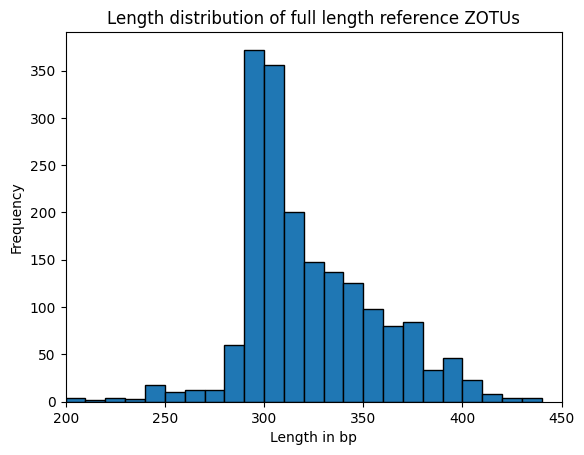

In [25]:
# Length of full length reference ZOTUs
display(md("## Sequence length of reference ZOTUs"))
display(df_refseq_full.describe())
xlim_low, xlim_high = 200, 450
bin_space = 10
bins = [xlim_low + i*bin_space for i in range(int((xlim_high-xlim_low)/bin_space))]
ax = df_refseq_full['refseq_length'].plot.hist(bins=bins, xlim=(xlim_low, xlim_high), edgecolor = "black")
ax.set_title("Length distribution of full length reference ZOTUs")
ax.set_xlabel("Length in bp")

plt.show()

In [26]:
#Comparing reference sequences before and after truncation

df_refseq_both = df[(df["passed_contam_full"]) | (df["passed_contam_trunc"])].drop_duplicates(
    subset=["location", "refsequence_pk_full", "refsequence_pk_trunc"])
df_refseq_both["refseq_full_exclusive_to_loc"] = ~(
    df_refseq_both["refsequence_pk_full"].isin(df_refseq_both[df_refseq_both["location"] == "A"]["refsequence_pk_full"]) &
    df_refseq_both["refsequence_pk_full"].isin(df_refseq_both[df_refseq_both["location"] == "B"]["refsequence_pk_full"]
))
df_refseq_both["refseq_trunc_exclusive_to_loc"] = ~(
    df_refseq_both["refsequence_pk_trunc"].isin(df_refseq_both[df_refseq_both["location"] == "A"]["refsequence_pk_trunc"]) &
    df_refseq_both["refsequence_pk_trunc"].isin(df_refseq_both[df_refseq_both["location"] == "B"]["refsequence_pk_trunc"]
))
df_refseq_both = df_refseq_both.merge(
    df_refseq_both[(df_refseq_both["passed_contam_full"] == True) & (df_refseq_both["passed_contam_trunc"] == True)][["location", "refsequence_pk_trunc"]].drop_duplicates(),
    how="left", indicator=True
).set_index(df_refseq_both.index)
df_refseq_both["refseq_trunc_new_to_loc"] = df_refseq_both["_merge"] == "left_only"
df_refseq_both = df_refseq_both.drop(columns=["_merge"])

df_refseq_both_full = df_refseq_both[df_refseq_both["passed_contam_full"] == True].drop_duplicates(subset=["refsequence_pk_full", "refsequence_pk_trunc"])
df_refseq_both_trunc = df_refseq_both[df_refseq_both["passed_contam_trunc"] == True].sort_values(
    by=["refseq_full_exclusive_to_loc", "refseq_trunc_new_to_loc"], ascending=False).drop_duplicates(subset=["passed_contam_full", "refsequence_pk_trunc"])

df_refseq_both_full_count = pd.DataFrame(
    df_refseq_both_full.value_counts(
        subset=["passed_trunc", "refseq_full_exclusive_to_loc", "refseq_trunc_exclusive_to_loc"])
).sort_index(level=["passed_trunc"], sort_remaining=False)

df_refseq_both_trunc_count = pd.DataFrame(
    df_refseq_both_trunc.value_counts(
        subset=["passed_contam_full", "refseq_full_exclusive_to_loc", "refseq_trunc_exclusive_to_loc", "refseq_trunc_new_to_loc"])
).sort_index(level=["passed_contam_full"], sort_remaining=False)

num_ref_full = df_refseq_full.shape[0]
num_ref_trunc = df_refseq.shape[0]

num_ref_full_discarded = df_refseq_both_full_count.loc[(False, slice(None), False)]["count"].sum()
num_ref_full_exclusive_both = df_refseq_both_full_count.loc[(True, True, True)]["count"].sum()
num_ref_full_not_exclusive_both = df_refseq_both_full_count.loc[(True, False, False)]["count"].sum()
num_ref_full_no_longer_exclusive = df_refseq_both_full_count.loc[(True, True, False)]["count"].sum()

num_ref_trunc_exclusive_new = df_refseq_both_trunc_count.loc[(False, False, True, True)]["count"].sum()
num_ref_trunc_not_exclusive_new = df_refseq_both_trunc_count.loc[(False, False, False, True)]["count"].sum()
num_ref_trunc_exclusive_both = df_refseq_both_trunc_count.loc[(True, True, True, False)]["count"].sum()
num_ref_trunc_not_exclusive_both = df_refseq_both_trunc_count.loc[(True, False, False, False)]["count"].sum()
num_ref_trunc_no_longer_exclusive = df_refseq_both_trunc_count.loc[(True, True, False, False)]["count"].sum()

display(md("## Comparing reference sequences before and after truncation"))
display(md(f"The number of reference sequences (unique ZOTUs across all samples) is:\n"
           f"- {num_ref_full} at full length\n"
           f"- {num_ref_trunc} when truncating"))
display(md("Of the full length reference sequences:"))
display(df_refseq_both_full_count)
display(md(f"- {num_ref_full_discarded} get discarded (<250bp)\n"
           f"- {num_ref_full_exclusive_both} are exclusive to their location both before and after truncation\n"
           f"- {num_ref_full_not_exclusive_both} are found in both locations before and after truncation\n"
           f"- {num_ref_full_no_longer_exclusive} are no longer exclusive to their location after truncation"))
display(md("Of the truncated reference sequences:"))
display(df_refseq_both_trunc_count)
display(md(f"- {num_ref_trunc_exclusive_new} are new to their location, resulting from the new ZOTUs, and exclusive to their location\n"
           f"- {num_ref_trunc_not_exclusive_new} are new to their location, but were already present in the other location\n"
           f"- {num_ref_trunc_exclusive_both} are exclusive to their location both before and after truncation\n"
           f"- {num_ref_trunc_not_exclusive_both} are found in both locations before and after truncation\n"
           f"- {num_ref_trunc_no_longer_exclusive} are no longer exclusive to their location after truncation\n"
           ))

## Comparing reference sequences before and after truncation

The number of reference sequences (unique ZOTUs across all samples) is:
- 1856 at full length
- 1767 when truncating

Of the full length reference sequences:

count
passed_trunc refseq_full_exclusive_to_loc refseq_trunc_exclusive_to_loc       
False        True                         False                             31
True         True                         True                            1757
             False                        False                             53
             True                         False                             15

- 31 get discarded (<250bp)
- 1757 are exclusive to their location both before and after truncation
- 53 are found in both locations before and after truncation
- 15 are no longer exclusive to their location after truncation

Of the truncated reference sequences:

count
passed_contam_full refseq_full_exclusive_to_loc refseq_trunc_exclusive_to_loc refseq_trunc_new_to_loc       
False              False                        True                          False                      184
                                                                              True                        30
                                                False                         False                       17
                                                                              True                         2
True               True                         True                          False                     1682
                   False                        False                         False                       44
                   True                         False                         False                       11

- 30 are new to their location, resulting from the new ZOTUs, and exclusive to their location
- 2 are new to their location, but were already present in the other location
- 1682 are exclusive to their location both before and after truncation
- 44 are found in both locations before and after truncation
- 11 are no longer exclusive to their location after truncation


# Taxonomy table results

In [27]:
# Taxonomic ranks array
ranks = ["phylum", "class", "order", "family", "genus", "species"]

count
passed_trunc tax_missing_full tax_missing_trunc refseq_full_exclusive_to_loc       
False        False            NaN               True                             21
             True             NaN               True                             10
True         False            False             True                           1549
                                                False                            50
             True             False             True                              4
                              True              True                            219
                                                False                             3

- 236 are missing a UNITE hit (12.72%)
	- 10 of these are discarded reference sequences (32.26% of total discarded)
	- 4 of these do have a UNITE hit after truncation (0.22% of reference sequences that pass truncation)
	- 3 of these are are found in both locations (5.66% of reference sequences found in both locations)

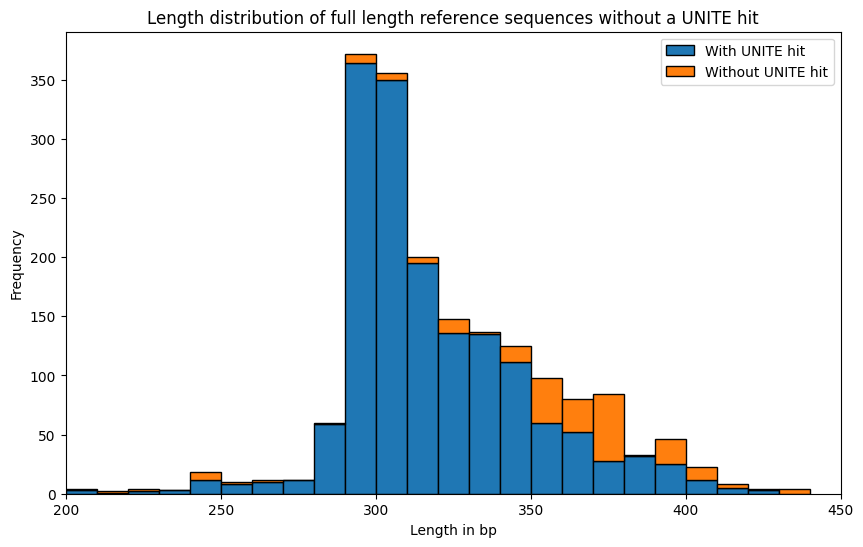

count
passed_contam_full tax_missing_full tax_missing_trunc refseq_trunc_exclusive_to_loc refseq_trunc_new_to_loc       
False              NaN              False             True                          False                      136
                                                                                    True                        23
                                                      False                         False                       15
                                                                                    True                         2
                                    True              True                          False                       48
                                                                                    True                         7
                                                      False                         False                        2
True               False            False             True                          False                     1481
                                                      False                         False                       52
                   True             False             True                          False                        4
                                    True              True                          False                      197
                                                      False                         False                        3

- 207 are missing a UNITE hit (11.71%)
	- 7 of these are new reference sequences (23.33% of new reference sequences)
	- 3 of these are found in both locations (5.26% of reference sequences found in both locations)

In [28]:
#Missing taxonomy analysis

df_refseq_both_full_notax_count = pd.DataFrame(df_refseq_both_full.value_counts(
    subset=["passed_trunc", "tax_missing_full", "tax_missing_trunc", "refseq_full_exclusive_to_loc"], dropna=False
)).sort_index(level=["passed_trunc", "tax_missing_full", "tax_missing_trunc"], sort_remaining=False)

df_refseq_both_trunc_notax_count = pd.DataFrame(df_refseq_both_trunc.value_counts(
    subset=["passed_contam_full", "tax_missing_full", "tax_missing_trunc", "refseq_trunc_exclusive_to_loc", "refseq_trunc_new_to_loc"], dropna=False
)).sort_index(level=["passed_contam_full", "tax_missing_full", "tax_missing_trunc"], sort_remaining=False)


num_ref_full_notax = df_refseq_both_full_notax_count.loc[(slice(None), True, slice(None), slice(None))]["count"].sum()
num_ref_full_notax_discard = df_refseq_both_full_notax_count.loc[(False, True, slice(None), slice(None))]["count"].sum()
num_ref_full_notax_no_longer = df_refseq_both_full_notax_count.loc[(True, True, False, slice(None))]["count"].sum()
num_ref_full_notax_not_exclusive = df_refseq_both_full_notax_count.loc[(True, True, slice(None), False)]["count"].sum()
display(df_refseq_both_full_notax_count)

display(md(f"- {num_ref_full_notax} are missing a UNITE hit ({num_ref_full_notax / num_ref_full:.2%})\n"
           f"\t- {num_ref_full_notax_discard} of these are discarded reference sequences ({num_ref_full_notax_discard / num_ref_full_discarded:.2%} of total discarded)\n"
           f"\t- {num_ref_full_notax_no_longer} of these do have a UNITE hit after truncation ({num_ref_full_notax_no_longer / (num_ref_full_exclusive_both + num_ref_full_not_exclusive_both + num_ref_full_no_longer_exclusive):.2%} of reference sequences that pass truncation)\n"
           f"\t- {num_ref_full_notax_not_exclusive} of these are are found in both locations ({num_ref_full_notax_not_exclusive / num_ref_full_not_exclusive_both:.2%} of reference sequences found in both locations)"))


ax = df_refseq_both_full.pivot(columns="tax_missing_full")["refseq_length_full"]\
    .rename(columns={True: "Without UNITE hit", False: "With UNITE hit"}).plot.hist(bins=bins, stacked=True, xlim=(200, 450), edgecolor = "black", figsize=(10,6))
ax.set_title("Length distribution of full length reference sequences without a UNITE hit")
ax.set_xlabel("Length in bp")
plt.legend() 
plt.show()


num_ref_trunc_notax_new = df_refseq_both_trunc_notax_count.loc[(False, slice(None), True, slice(None), True)]["count"].sum()
num_ref_trunc_notax_overlap = df_refseq_both_trunc_notax_count.loc[(True, slice(None), True, slice(None), False)]["count"].sum()
num_ref_trunc_notax = num_ref_trunc_notax_new + num_ref_trunc_notax_overlap
num_ref_trunc_notax_not_exclusive = df_refseq_both_trunc_notax_count.loc[(True, slice(None), True, False, False)]["count"].sum()

display(df_refseq_both_trunc_notax_count)

display(md(f"- {num_ref_trunc_notax} are missing a UNITE hit ({num_ref_trunc_notax / num_ref_trunc:.2%})\n"
           f"\t- {num_ref_trunc_notax_new} of these are new reference sequences ({num_ref_trunc_notax_new / num_ref_trunc_exclusive_new:.2%} of new reference sequences)\n"
           f"\t- {num_ref_trunc_notax_not_exclusive} of these are found in both locations ({num_ref_trunc_notax_not_exclusive / (num_ref_trunc_not_exclusive_both + num_ref_trunc_not_exclusive_new + num_ref_trunc_no_longer_exclusive):.2%} of reference sequences found in both locations)"))


count refseq  \
UNITE_id_in_refseq_full UNITE_id_in_refseq_trunc tax_in_refseq_full_lowest tax_in_refseq_trunc_lowest                 
False                   False                    species                   species                               15   
                                                 order                     order                                  4   
                                                 class                     species                                1   
True                    True                     species                   species                                1   

                                                                                                       count UNITE_id  
UNITE_id_in_refseq_full UNITE_id_in_refseq_trunc tax_in_refseq_full_lowest tax_in_refseq_trunc_lowest                  
False                   False                    species                   species                                 10  
                                                 order                     order                                    3  
                                                 class                     species                                  1  
True                    True                     species                   species                                  1

count refseq  \
UNITE_id_in_refseq_full UNITE_id_in_refseq_trunc tax_in_refseq_full_lowest tax_in_refseq_trunc_lowest                 
True                    True                     species                   species                               13   
False                   False                    species                   species                                5   
                                                 order                     order                                  3   
                                                 family                    family                                 2   
                                                 class                     class                                  1   
                                                 species                   class                                  1   

                                                                                                       count UNITE_id  
UNITE_id_in_refseq_full UNITE_id_in_refseq_trunc tax_in_refseq_full_lowest tax_in_refseq_trunc_lowest                  
True                    True                     species                   species                                 12  
False                   False                    species                   species                                  5  
                                                 order                     order                                    3  
                                                 family                    family                                   2  
                                                 class                     class                                    1  
                                                 species                   class                                    1

count refseq  \
UNITE_id_in_refseq_trunc tax_in_refseq_trunc_lowest                 
True                     species                             1389   
False                    genus                                145   
                         species                               62   
                         family                                36   
                         order                                 16   
                         class                                  1   

                                                     count UNITE_id  
UNITE_id_in_refseq_trunc tax_in_refseq_trunc_lowest                  
True                     species                                830  
False                    genus                                   88  
                         species                                 49  
                         family                                  25  
                         order                                   12  
                         class                                    1

count refseq  count UNITE_id mapping
UNITE_id_equal tax_equal_lowest                                      
True           species                   1327                     829
False          genus                      148                     115
               family                      51                      41
               order                       41                      27
               species                     37                      34
               phylum                      25                      13
               none                        12                       8
               class                        8                       7

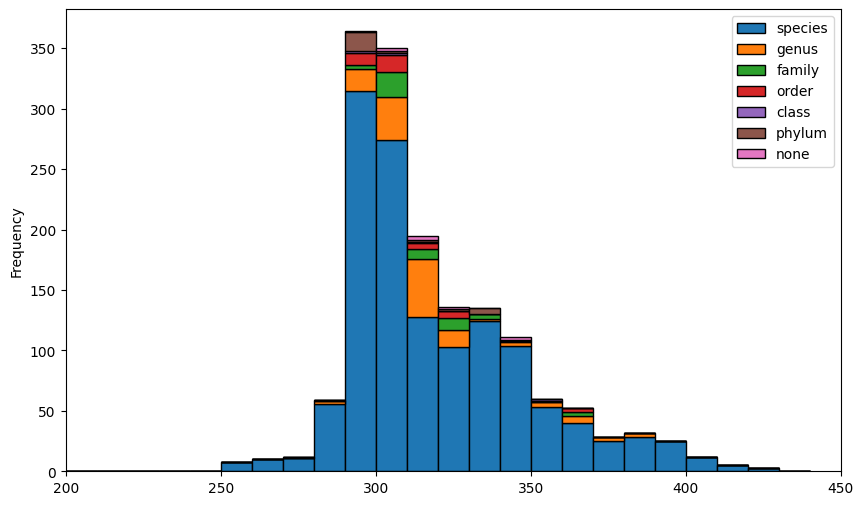

In [36]:
#Create UNITE id dataframes
df_unite_full = df[df["tax_missing_full"] == False].drop_duplicates(subset=["location", "UNITE_id_full"])
df_unite_not_discard = df[(df["passed_trunc"] == True) & (df["tax_missing_full"] == False)].drop_duplicates(subset=["location", "UNITE_id_full"])
df_unite_trunc = df[df["tax_missing_trunc"] == False].drop_duplicates(subset=["location", "UNITE_id_trunc"])
df_unite_not_new = df_refseq_both[
    (df_refseq_both["passed_contam_trunc"] == True) &
    (df_refseq_both["refseq_trunc_new_to_loc"] == False) &
    (df_refseq_both["tax_missing_trunc"] == False)].drop_duplicates(subset=["location", "UNITE_id_trunc"])

df_refseq_unite_discard = df_refseq_both[(df_refseq_both["passed_trunc"] == False) & (df_refseq_both["tax_missing_full"] == False)].copy()
df_refseq_unite_new = df_refseq_both[(df_refseq_both["passed_contam_trunc"] == True) & (df_refseq_both["refseq_trunc_new_to_loc"] == True) &
    (df_refseq_both["tax_missing_trunc"] == False)].copy()
df_refseq_unite_both = df_refseq_both[(df_refseq_both["tax_missing_full"] == False) & (df_refseq_both["tax_missing_trunc"] == False)].copy()

# Analyse discarded

for suffix, merge_df in [("full", df_unite_not_discard), ("trunc", df_unite_trunc)]:

    df_refseq_unite_discard = df_refseq_unite_discard.merge(
        merge_df[["location", f"UNITE_id_{suffix}"]].rename(columns={f"UNITE_id_{suffix}": "UNITE_id_full"}),
        on=["location","UNITE_id_full"], how="left", indicator=True).set_index(df_refseq_unite_discard.index)
    df_refseq_unite_discard[f"UNITE_id_in_refseq_{suffix}"] = df_refseq_unite_discard["_merge"] == "both"
    df_refseq_unite_discard = df_refseq_unite_discard.drop(columns=["_merge"])

    for rank_depth in range(len(ranks)):
        df_tax_until_rank = merge_df[["location"]+[f"{rank}_{suffix}" for rank in ranks[:rank_depth+1]]].drop_duplicates()
        df_refseq_unite_discard = df_refseq_unite_discard.merge(
            df_tax_until_rank.rename(columns={f"{rank}_{suffix}": f"{rank}_full" for rank in ranks[:rank_depth+1]}),
            how="left", indicator=True).set_index(df_refseq_unite_discard.index)
        df_refseq_unite_discard[f"tax_in_refseq_{suffix}_until_{ranks[rank_depth]}"] = df_refseq_unite_discard["_merge"] == "both"
        df_refseq_unite_discard = df_refseq_unite_discard.drop(columns=["_merge"])

    df_refseq_unite_discard[f"tax_in_refseq_{suffix}_lowest"] = (
        df_refseq_unite_discard[[f"tax_in_refseq_{suffix}_until_{rank}" for rank in ranks]].apply(
            lambda row: next((rank for rank in ranks[::-1] if row[f"tax_in_refseq_{suffix}_until_{rank}"]), None), axis=1
        )
    )

df_unite_discard = df_refseq_unite_discard.drop_duplicates(subset=["location", "UNITE_id_full"])
df_unite_discard_counts = pd.DataFrame.join(
    df_refseq_unite_discard.value_counts(subset=["UNITE_id_in_refseq_full", "UNITE_id_in_refseq_trunc", "tax_in_refseq_full_lowest","tax_in_refseq_trunc_lowest"]),
    df_unite_discard.value_counts(subset=["UNITE_id_in_refseq_full", "UNITE_id_in_refseq_trunc", "tax_in_refseq_full_lowest","tax_in_refseq_trunc_lowest"]),
    lsuffix=" refseq", rsuffix=" UNITE_id"
)

display(df_unite_discard_counts)

# Analyze new refseqs

for suffix, merge_df in [("full", df_unite_full), ("trunc", df_unite_not_new)]:

    df_refseq_unite_new = df_refseq_unite_new.merge(
        merge_df[["location", f"UNITE_id_{suffix}"]].rename(columns={f"UNITE_id_{suffix}": "UNITE_id_trunc"}),
        on=["location","UNITE_id_trunc"], how="left", indicator=True).set_index(df_refseq_unite_new.index)
    df_refseq_unite_new[f"UNITE_id_in_refseq_{suffix}"] = df_refseq_unite_new["_merge"] == "both"
    df_refseq_unite_new = df_refseq_unite_new.drop(columns=["_merge"])

    for rank_depth in range(len(ranks)):
        df_tax_until_rank = merge_df[["location"]+[f"{rank}_{suffix}" for rank in ranks[:rank_depth+1]]].drop_duplicates()
        df_refseq_unite_new = df_refseq_unite_new.merge(
            df_tax_until_rank.rename(columns={f"{rank}_{suffix}": f"{rank}_trunc" for rank in ranks[:rank_depth+1]}),
            how="left", indicator=True).set_index(df_refseq_unite_new.index)
        df_refseq_unite_new[f"tax_in_refseq_{suffix}_until_{ranks[rank_depth]}"] = df_refseq_unite_new["_merge"] == "both"
        df_refseq_unite_new = df_refseq_unite_new.drop(columns=["_merge"])

    df_refseq_unite_new[f"tax_in_refseq_{suffix}_lowest"] = (
        df_refseq_unite_new[[f"tax_in_refseq_{suffix}_until_{rank}" for rank in ranks]].apply(
            lambda row: next((rank for rank in ranks[::-1] if row[f"tax_in_refseq_{suffix}_until_{rank}"]), "none"), axis=1
        )
    )

df_unite_new = df_refseq_unite_new.drop_duplicates(subset=["location", "UNITE_id_trunc"])
df_unite_new_counts = pd.DataFrame.join(
    df_refseq_unite_new.value_counts(subset=["UNITE_id_in_refseq_full", "UNITE_id_in_refseq_trunc", "tax_in_refseq_full_lowest","tax_in_refseq_trunc_lowest"]),
    df_unite_new.value_counts(subset=["UNITE_id_in_refseq_full", "UNITE_id_in_refseq_trunc", "tax_in_refseq_full_lowest","tax_in_refseq_trunc_lowest"]),
    lsuffix=" refseq", rsuffix=" UNITE_id"
)

display(df_unite_new_counts)


# Analyze refseqs that have a UNITE hit before and after truncation
df_refseq_unite_both["UNITE_id_equal"] = df_refseq_unite_both["UNITE_id_full"] == df_refseq_unite_both["UNITE_id_trunc"]

def deepest_rank_equal(row):
    last_rank_equal = "none"
    for rank in ranks:
        if row[f"{rank}_full"] == row[f"{rank}_trunc"]:
            last_rank_equal = rank
        else:
            break
    return last_rank_equal

df_refseq_unite_both["tax_equal_lowest"] = df_refseq_unite_both.apply(deepest_rank_equal, axis=1)

df_refseq_unite_both = df_refseq_unite_both.merge(
    df_unite_trunc[["location", f"UNITE_id_trunc"]].rename(columns={f"UNITE_id_trunc": "UNITE_id_full"}),
    on=["location","UNITE_id_full"], how="left", indicator=True).set_index(df_refseq_unite_both.index)
df_refseq_unite_both[f"UNITE_id_in_refseq_trunc"] = df_refseq_unite_both["_merge"] == "both"
df_refseq_unite_both = df_refseq_unite_both.drop(columns=["_merge"])

for rank_depth in range(len(ranks)):
    df_tax_until_rank = df_unite_trunc[["location"]+[f"{rank}_trunc" for rank in ranks[:rank_depth+1]]].drop_duplicates()
    df_refseq_unite_both = df_refseq_unite_both.merge(
        df_tax_until_rank.rename(columns={f"{rank}_trunc": f"{rank}_full" for rank in ranks[:rank_depth+1]}),
        how="left", indicator=True).set_index(df_refseq_unite_both.index)
    df_refseq_unite_both[f"tax_in_refseq_trunc_until_{ranks[rank_depth]}"] = df_refseq_unite_both["_merge"] == "both"
    df_refseq_unite_both = df_refseq_unite_both.drop(columns=["_merge"])

df_refseq_unite_both[f"tax_in_refseq_trunc_lowest"] = (
    df_refseq_unite_both[[f"tax_in_refseq_{suffix}_until_{rank}" for rank in ranks]].apply(
        lambda row: next((rank for rank in ranks[::-1] if row[f"tax_in_refseq_{suffix}_until_{rank}"]), "none"), axis=1
    )
)

df_unite_both_full = df_refseq_unite_both.drop_duplicates(subset=["location", "UNITE_id_full"])
df_unite_both_count_overlap = pd.DataFrame.join(
    df_refseq_unite_both.value_counts(subset=["UNITE_id_in_refseq_trunc", "tax_in_refseq_trunc_lowest"]),
    df_unite_both_full.value_counts(subset=["UNITE_id_in_refseq_trunc", "tax_in_refseq_trunc_lowest"]),
    lsuffix=" refseq", rsuffix=" UNITE_id"
)

df_unite_both = df_refseq_unite_both.drop_duplicates(subset=["location", "UNITE_id_full", "UNITE_id_trunc"])
df_unite_both_count_equal = pd.DataFrame.join(
    df_refseq_unite_both.value_counts(subset=["UNITE_id_equal", "tax_equal_lowest"]),
    df_unite_both.value_counts(subset=["UNITE_id_equal", "tax_equal_lowest"]), lsuffix=" refseq", rsuffix=" UNITE_id mapping"
)

display(df_unite_both_count_overlap)
display(df_unite_both_count_equal)


df_refseq_unite_both_global = df_refseq_unite_both.drop_duplicates(subset=["refsequence_pk_full"])
df_refseq_unite_both_global.pivot(columns="tax_equal_lowest")["refseq_length_full"].reindex(ranks[::-1]+["none"], axis=1).plot.hist(bins=bins, stacked=True, xlim=(200, 450), edgecolor = "black", figsize=(10,6))

plt.legend()
plt.show()



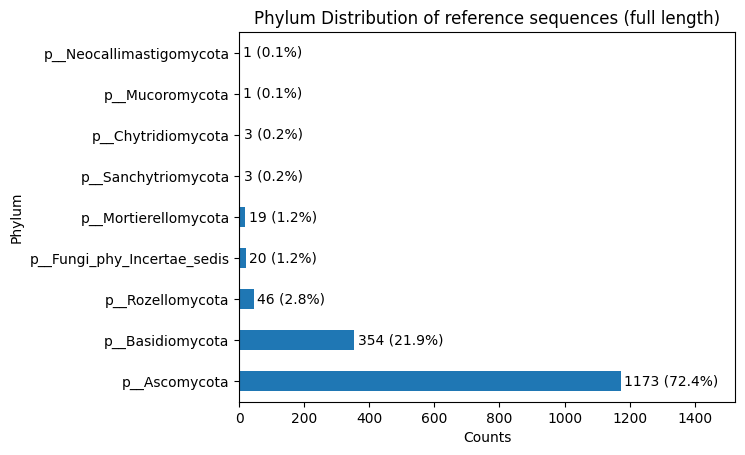

In [30]:
value_counts = df_refseq_tax_full["phylum"].value_counts()
proportions = value_counts / value_counts.sum()
ax = value_counts.plot.barh(xlim=(0, value_counts.max() * 1.3))

for index, (count, proportion) in enumerate(zip(value_counts, proportions)):
    ax.text(count + 10, index, f"{count} ({proportion:.1%})", va='center')

ax.set_xlabel("Counts")
ax.set_ylabel("Phylum")
ax.set_title("Phylum Distribution of reference sequences (full length)")

plt.show()

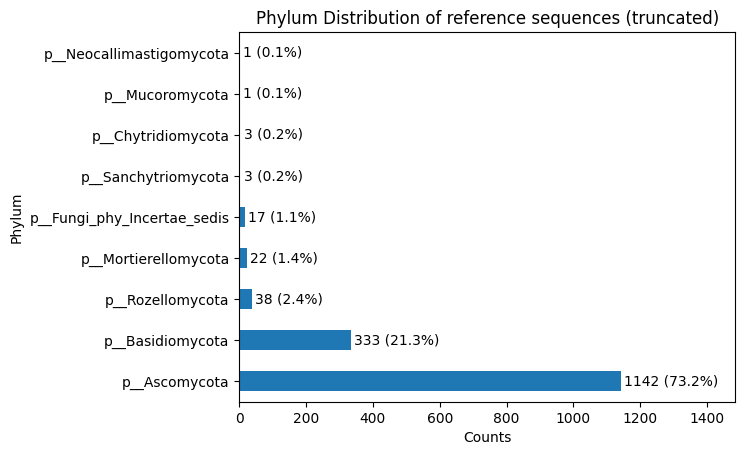

In [31]:
value_counts = df_refseq_tax["phylum"].value_counts()
proportions = value_counts / value_counts.sum()
ax = value_counts.plot.barh(xlim=(0, value_counts.max() * 1.3))

for index, (count, proportion) in enumerate(zip(value_counts, proportions)):
    ax.text(count + 10, index, f"{count} ({proportion:.1%})", va='center')

ax.set_xlabel("Counts")
ax.set_ylabel("Phylum")
ax.set_title("Phylum Distribution of reference sequences (truncated)")

plt.show()